## Prepare Data ##

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import math

# Model Parameters
training_batch_size = 8
num_epochs_encoder = 50
num_epochs_decoder = 120
encoder_learning_rate = 0.004
decoder_learning_rate = 0.015

# Training / Validation Dataset
class SimulatorDataset(Dataset):
    """Simulator Data Dataset with normalization."""
    def __init__(self, csv_file, root_dir, transform=None):
        self.params_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Get feature data
        self.features = self.params_frame.loc[:, "ROB Size":"CPU Fetch Width"].values
        
        # Normalize the label data
        self.label_scaler = MinMaxScaler()
        target = self.params_frame.loc[:, "Number of Cycles":"Power"].values
        self.normalized_target = self.label_scaler.fit_transform(target)
    
    def __len__(self):
        return len(self.params_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.features[idx]
        target = self.normalized_target[idx]

        # Re-encode data
        one_hot_data = []

        # Encode ROB entries
        num_rob_entries = data[0]
        match num_rob_entries:
            case 16:
                one_hot_data.extend([1, 0, 0, 0, 0, 0, 0])
            case 32:
                one_hot_data.extend([0, 1, 0, 0, 0, 0, 0])
            case 64:
                one_hot_data.extend([0, 0, 1, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 0, 0, 1, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 0, 0, 1, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 0, 0, 1, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError
        
        # Encode IQ entries
        num_iq_entries = data[1]
        match num_iq_entries:
            case 16:
                one_hot_data.extend([1, 0, 0, 0, 0, 0, 0])
            case 32:
                one_hot_data.extend([0, 1, 0, 0, 0, 0, 0])
            case 64:
                one_hot_data.extend([0, 0, 1, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 0, 0, 1, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 0, 0, 1, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 0, 0, 1, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError
        
        # Encode LQ entries
        num_lq_entries = data[2]
        match num_lq_entries:
            case 16:
                one_hot_data.extend([1, 0, 0, 0, 0, 0])
            case 64:
                one_hot_data.extend([0, 1, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 0, 1, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 0, 1, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 0, 1, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError
        
        # Encode SQ entries
        num_sq_entries = data[3]
        match num_sq_entries:
            case 16:
                one_hot_data.extend([1, 0, 0, 0, 0, 0])
            case 64:
                one_hot_data.extend([0, 1, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 0, 1, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 0, 1, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 0, 1, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError
        
        # Encode phys regs
        num_phys_reg = data[4]
        match num_phys_reg:
            case 64:
                one_hot_data.extend([1, 0, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 1, 0, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 1, 0, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 1, 0, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 1, 0])
            case 2048:
                one_hot_data.extend([0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError

        # Encode cpu width
        cpu_width = data[5]
        match cpu_width:
            case 2:
                one_hot_data.extend([1, 0, 0, 0])
            case 4:
                one_hot_data.extend([0, 1, 0, 0])
            case 6:
                one_hot_data.extend([0, 0, 1, 0])
            case 8:
                one_hot_data.extend([0, 0, 0, 1])
            case _:
                raise NotImplementedError
        
        sample = {'data': np.array(one_hot_data), 'target': target}
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

# Get dataset
sim_dataset = SimulatorDataset(csv_file='./modified_example.csv', root_dir='.',transform=None)

# Split into training and validation data (3 : 1 split)
val_dataset_size = len(sim_dataset) // 4
train_dataset_size = len(sim_dataset) - val_dataset_size
train_set, val_set = torch.utils.data.random_split(sim_dataset, [train_dataset_size, val_dataset_size])

# Prepare data loader
train_loader = DataLoader(train_set, batch_size=training_batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=training_batch_size, shuffle=True)

## Define Model ##

In [2]:
# Encoder Architecture
class EncoderMLP(nn.Module):
    def __init__(self):
        super(EncoderMLP, self).__init__()
        # Hidden Encoder Dim Layer 1
        self.layer1 = nn.Linear(36, 45)
        # Activation Function
        self.tanh1 = nn.Tanh()
        # Hidden Encoder Dim Layer 2
        self.layer2 = nn.Linear(45, 20)
        # Activation Function
        self.tanh2 = nn.Tanh()
        # Hidden Encoder Dim Layer 3
        self.layer3 = nn.Linear(20, 2)
        # Activation Function
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh1(x)
        x = self.layer2(x)
        x = self.tanh2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

# Decoder Architecture
class DecoderMLP(nn.Module):
    def __init__(self):
        super(DecoderMLP, self).__init__()
        # Hidden Encoder Dim Layer 1
        self.layer1 = nn.Linear(2, 20)
        # Activation Function
        self.tanh1 = nn.Tanh()
        # Hidden Encoder Dim Layer 2
        self.layer2 = nn.Linear(20, 80)
        # Activation Function
        self.tanh2 = nn.Tanh()
        # Hidden Encoder Dim Layer 3
        self.layer3 = nn.Linear(80, 36)
        # Activation Function
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh1(x)
        x = self.layer2(x)
        x = self.tanh2(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

## Forward Training ##

### Encoder Training ###

In [3]:
# Initialize the encoder
encoder = EncoderMLP()

# Train encoder model first

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=encoder_learning_rate)

# Track training and validation loss per epoch
train_losses = []
val_losses = []

# Get initial losses

# Training loss
train_loss = count = 0
for i, batch in enumerate(train_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass
    outputs = encoder(data)
    loss = criterion(outputs, target)
    # Update training accuracy
    train_loss += loss
    count += 1
# Get final epoch train loss
train_loss = train_loss / count
train_losses.append(train_loss.detach().numpy())

# Val loss
val_loss = count = 0
for i, batch in enumerate(val_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass
    outputs = encoder(data)
    loss = criterion(outputs, target)
    # Update validation accuracy
    val_loss += loss
    count += 1
# Get final epoch validation loss
val_loss = val_loss / count
val_losses.append(val_loss.detach().numpy())

# Train the model
for epoch in range(num_epochs_encoder):

    # Report training accuracy
    train_loss = count = 0

    for i, batch in enumerate(train_loader):
        # free the gradient from the previous batch
        optimizer.zero_grad()

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()

        # Forward pass
        outputs = encoder(data)
        loss = criterion(outputs, target)

        # model backward
        loss.backward()
        # update the model paramters
        optimizer.step()

        # Update training accuracy
        train_loss += loss
        count += 1

    # Get final epoch train loss
    train_loss = train_loss / count
    train_losses.append(train_loss.detach().numpy())

    # Report validation accuracy
    val_loss = count = 0

    # Get validation loss (we only actually care about first 2 data points)
    for i, batch in enumerate(val_loader):

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()
        
        # Forward pass
        outputs = encoder(data)

        # Calculate loss
        loss = criterion(outputs, target)

        # Update validation accuracy
        val_loss += loss
        count += 1
    
    # Get final epoch validation loss
    val_loss = val_loss / count
    val_losses.append(val_loss.detach().numpy())

    # Print status check
    print(f"Epoch: [{epoch+1}/{num_epochs_encoder}], train_loss: {train_loss}, val_loss: {val_loss}")

Epoch: [1/50], train_loss: 0.01088698673993349, val_loss: 0.0045021758414804935
Epoch: [2/50], train_loss: 0.0026812306605279446, val_loss: 0.002514504361897707
Epoch: [3/50], train_loss: 0.0016926095122471452, val_loss: 0.0016335323452949524
Epoch: [4/50], train_loss: 0.0012639971682801843, val_loss: 0.001305252080783248
Epoch: [5/50], train_loss: 0.001104006776586175, val_loss: 0.001509465160779655
Epoch: [6/50], train_loss: 0.0009330500615760684, val_loss: 0.0009086092468351126
Epoch: [7/50], train_loss: 0.0008249670499935746, val_loss: 0.000864461762830615
Epoch: [8/50], train_loss: 0.0007856558659113944, val_loss: 0.0009490805095992982
Epoch: [9/50], train_loss: 0.0007153107435442507, val_loss: 0.0007334200199693441
Epoch: [10/50], train_loss: 0.0006934278644621372, val_loss: 0.0008443958940915763
Epoch: [11/50], train_loss: 0.0006441570003516972, val_loss: 0.0006994830910116434
Epoch: [12/50], train_loss: 0.0005743206711485982, val_loss: 0.0008357957121916115
Epoch: [13/50], trai

### Encoder Results ###

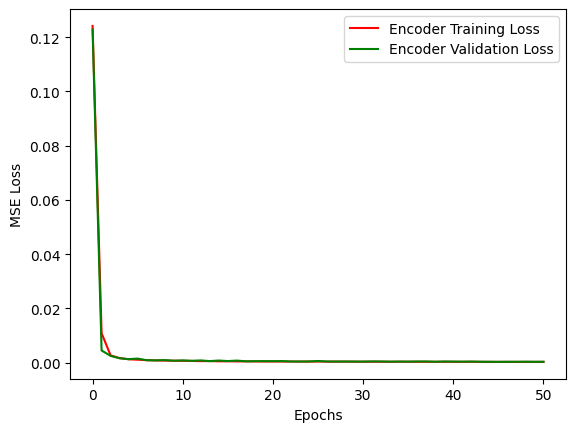

Final validation loss: 0.0003588463587220758


In [4]:
# Get x axis
x_data = [x for x in range(num_epochs_encoder + 1)]

# Plot data
plt.plot(x_data, train_losses, c='r', label="Encoder Training Loss")
plt.plot(x_data, val_losses, c='g', label="Encoder Validation Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

# Report final data
print(f"Final validation loss: {val_losses[-1]}")

### Decoder (Inverse) Training ###

In [5]:
# Initialize the decoder
decoder = DecoderMLP()

# Now, we train decoder based on encoder output

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=decoder_learning_rate)

# Track training and validation loss per epoch
train_losses = []
val_losses = []

# Get initial losses

# Training loss
train_loss = count = 0
for i, batch in enumerate(train_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass (through encoder and decoder)
    outputs = encoder(data)
    outputs = decoder(outputs)
    # Calculate loss (compare output against incoming data)
    loss = criterion(outputs, data)
    # Update training accuracy
    train_loss += loss
    count += 1
# Get final epoch train loss
train_loss = train_loss / count
train_losses.append(train_loss.detach().numpy())

# Val loss
val_loss = count = 0
for i, batch in enumerate(val_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass (through encoder and decoder)
    outputs = encoder(data)
    outputs = decoder(outputs)
    # Calculate loss (compare output against incoming data)
    loss = criterion(outputs, data)
    # Update validation accuracy
    val_loss += loss
    count += 1
# Get final epoch validation loss
val_loss = val_loss / count
val_losses.append(val_loss.detach().numpy())

# Train the model
for epoch in range(num_epochs_decoder):

    # Report training accuracy
    train_loss = count = 0

    for i, batch in enumerate(train_loader):

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()

        # Forward pass to get encoder output
        encoder_output = encoder(data)

        # free the gradient from the previous batch
        optimizer.zero_grad()

        # Forward pass for decoder (compare against data)
        outputs = decoder(encoder_output)
        loss = criterion(outputs, data)

        # model backward
        loss.backward()
        # update the model paramters
        optimizer.step()

        # Update training accuracy
        train_loss += loss
        count += 1

    # Get final epoch train loss
    train_loss = train_loss / count
    train_losses.append(train_loss.detach().numpy())

    # Report validation accuracy
    val_loss = count = 0

    # Get validation loss (we only actually care about first 2 data points)
    for i, batch in enumerate(val_loader):

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()
        
        # Forward pass (through encoder and decoder)
        outputs = encoder(data)
        outputs = decoder(outputs)

        # Calculate loss (compare output against incoming data)
        loss = criterion(outputs, data)

        # Update validation accuracy
        val_loss += loss
        count += 1
    
    # Get final epoch validation loss
    val_loss = val_loss / count
    val_losses.append(val_loss.detach().numpy())

    # Print status check
    print(f"Epoch: [{epoch+1}/{num_epochs_decoder}], train_loss: {train_loss}, val_loss: {val_loss}")

Epoch: [1/120], train_loss: 0.1306762993335724, val_loss: 0.12982141971588135
Epoch: [2/120], train_loss: 0.12891723215579987, val_loss: 0.12802408635616302
Epoch: [3/120], train_loss: 0.12819911539554596, val_loss: 0.12869389355182648
Epoch: [4/120], train_loss: 0.12789848446846008, val_loss: 0.12853796780109406
Epoch: [5/120], train_loss: 0.12757912278175354, val_loss: 0.12806199491024017
Epoch: [6/120], train_loss: 0.12719523906707764, val_loss: 0.12715008854866028
Epoch: [7/120], train_loss: 0.12688596546649933, val_loss: 0.12620645761489868
Epoch: [8/120], train_loss: 0.12666800618171692, val_loss: 0.12622973322868347
Epoch: [9/120], train_loss: 0.12654606997966766, val_loss: 0.12569259107112885
Epoch: [10/120], train_loss: 0.12643560767173767, val_loss: 0.12643113732337952
Epoch: [11/120], train_loss: 0.12633176147937775, val_loss: 0.12591035664081573
Epoch: [12/120], train_loss: 0.1262938380241394, val_loss: 0.1259489804506302
Epoch: [13/120], train_loss: 0.1262437403202057, val

### Decoder (Inverse) Results ###

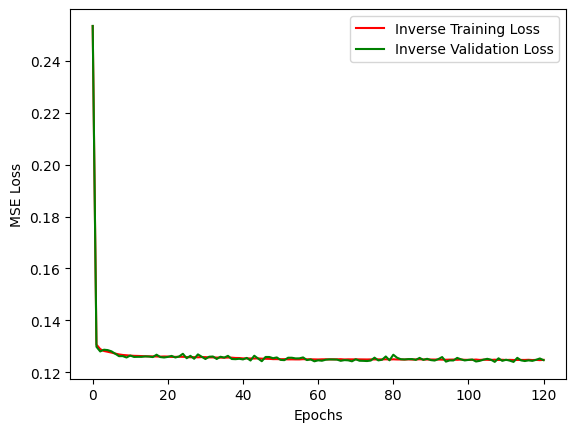

Final inverse validation loss: 0.12466170638799667


In [6]:
# Get x axis
x_data = [x for x in range(num_epochs_decoder + 1)]

# Plot data
plt.plot(x_data, train_losses, c='r', label="Inverse Training Loss")
plt.plot(x_data, val_losses, c='g', label="Inverse Validation Loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

# Report final data
print(f"Final inverse validation loss: {val_losses[-1]}")